In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random
import math

## Linear model and Optimizer

Defining the linear model and linear optimizer classes needed for the algorithm 1



In [2]:
import torch
import abc

from abc import ABC


# The linear model which implemented by pytorch
class TorchLinearModel(torch.nn.Module):
    def __init__(self, n):
        super(TorchLinearModel, self).__init__()
        self.linear = torch.nn.Linear(n, 1, bias=False)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred
    
    
# The abstract optimizer model which should have model, optimizer, and criterion
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(5):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear.weight - torch_old_weight) ** 2) 
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()
    
    
# The Linear optimizer model which implemented by pytorch    
class TorchLinearOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLinearOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLinearOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)
    
    
# The linear model in Networked Linear Regression section of the paper    
class LinearModel:
    def __init__(self, degree, features, label):
        
        mtx1 = 2 * degree * np.dot(features.T, features).astype('float64')
        mtx1 += 1 * np.eye(mtx1.shape[0])
        mtx1_inv = np.linalg.inv(mtx1)
        
        mtx2 = 2 * degree * np.dot(features.T, label).T
        
        self.mtx1_inv = mtx1_inv
        self.mtx2 = mtx2

    def forward(self, x):
        mtx2 = x + self.mtx2
        mtx_inv = self.mtx1_inv

        return np.dot(mtx_inv, mtx2)


# The Linear optimizer in Networked Linear Regression section of the paper    
class LinearOptimizer(Optimizer):

    def __init__(self, model):
        super(LinearOptimizer, self).__init__(model, None, None)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return self.model.forward(old_weight)



## Create SBM

Creating the SBM with two clusters $|C_1| = |C_2| = 100$. Two nodes within the same cluster are connected by an edge with probability pin, Two nodes from different clusters are connected by an edge with probability pout.
Each node $i ∈ V$ represents a local dataset consisting of $m$ feature vectors $x^{(i,1)} , . . . , x^{(i,m)} \in R^n$ . The feature vectors are i.i.d. realizations of a standard Gaussian random vector $x ∼ N(0,I)$.
The labels $y^{(i)}_1,...,y^{(i)}_m \in R$ of the nodes $i \in V$ are generated according to the linear model $y^{(i)}_r = (x^{(i,r)})^T \bar{w}^{(i)} + \epsilon$, with $\epsilon ∼ N(0, \sigma)$, weight vector $w^{(i)} = (2, 2)^T$ for $i \in C_1$ and $w^{(i)} = (−2,2)^T$ for $i \in C_2$ .

In [3]:
from torch.autograd import Variable
from graspy.simulations import sbm


def get_sbm_2blocks_data(m=5, n=2, pin=0.5, pout=0.001, noise_sd=0, is_torch_model=True):
    '''
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''
    N1, N2 = 100, 100

    # generate graph G which is a SBM wich 2 clusters
    G = sbm(n=[N1, N2], p=[[pin, pout],[pout, pin]], )
    '''
    G: generated SBM graph with 2 clusters
    '''

    N = len(G)
    E = int(len(np.argwhere(G > 0))/2)
    '''
    N: total number of nodes
    E: total number of edges
    '''
    
    
    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph with the shape of E*N
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph with the shape of E
    '''
    
    cnt = 0
    for i, j in np.argwhere(G > 0):
        if i > j:
            continue
        B[cnt, i] = 1
        B[cnt, j] = -1

        weight_vec[cnt] = 1
        cnt += 1
        
    
    # define weight vectors for each cluster of the graph
    
    W1 = np.array([2, 2])
    '''
    W1: the weigh vector for the first cluster
    '''
    W2 = np.array([-2, 2])
    '''
    W2: the weigh vector for the second cluster
    '''
    
    
    # create the data of each node needed for the algorithm 1 
    
    node_degrees = np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    '''
    node_degrees: a list containing the nodes degree for the alg1 (1/N_i)
    '''
    
    datapoints = {}
    '''
    datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1,
    which are features, label, degree, and also the optimizer model for each node
    '''
    true_labels = []
    '''
    true_labels: the true labels for the nodes of the graph
    '''
    for i in range(N):
        features = np.random.normal(loc=0.0, scale=1.0, size=(m, n))
        '''
        features: the feature vector of node i which are i.i.d. realizations of a standard Gaussian random vector x~N(0,I)
        '''
        
        if i < N1: # nodes in the first cluster
            label = np.dot(features, W1) + np.random.normal(0,noise_sd)
        else: # nodes in the second cluster
            label = np.dot(features, W2) + np.random.normal(0,noise_sd)
        '''
        label: the label of the node i that is generated according to the linear model y = x^T w + e
        '''
            
        true_labels.append(label)
            
        if is_torch_model:
            model = TorchLinearModel(n)
            optimizer = TorchLinearOptimizer(model)
        else:
            
            model = LinearModel(node_degrees[i], features, label)
            optimizer = LinearOptimizer(model)            
        '''
        model : the linear model for the node i 
        optimizer : the optimizer model for the node i 
        '''    
            
        datapoints[i] = {
            'features': Variable(torch.from_numpy(features)).to(torch.float32),
            'degree': node_degrees[i],
            'label': Variable(torch.from_numpy(label)).to(torch.float32),
            'optimizer': optimizer
        }
        

    return B, weight_vec, np.array(true_labels), datapoints


## Penalty Function

Defining the penalty functions for the algorithm 1 which are norm1, norm2, or mocha



In [4]:
# The abstract penalty function which has a function update
class Penalty(ABC):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        self.lambda_lasso = lambda_lasso
        self.weight_vec = weight_vec
        self.Sigma = Sigma

    @abc.abstractmethod
    def update(self, new_u):
        pass


# The norm2 penalty function
class Norm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array(lambda_lasso * weight_vec)

    def update(self, new_u):
        normalized_u = np.where(np.linalg.norm(new_u, axis=1) >= self.limit)
        new_u[normalized_u] = (new_u[normalized_u].T * self.limit[normalized_u] / np.linalg.norm(new_u[normalized_u], axis=1)).T
        return new_u


# The MOCHA penalty function
class MOCHAPelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(MOCHAPelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(2 * self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u

    
# The norm1 penalty function
class Norm1Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm1Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array([np.zeros(n) for i in range(len(weight_vec))])
        for i in range(n):
            self.limit[:, i] = lambda_lasso * weight_vec

    def update(self, new_u):
        normalized_u = np.where(abs(new_u) >= self.limit)
        new_u[normalized_u] = self.limit[normalized_u] * new_u[normalized_u] / abs(new_u[normalized_u])
        return new_u


## Algorithm 1


In [5]:
def algorithm_1(K, D, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func_name='norm1', calculate_score=False):
    '''
    :param K: the number of iterations 
    :param D: the block incidence matrix 
    :param weight_vec: a list containing the edges's weights of the graph
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set 
    :param lambda_lasso: the parameter lambda 
    :param penalty_func_name: the name of the penalty function used in the algorithm
    
    
    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''
    
    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    '''
    Sigma: the block diagonal matrix Sigma
    '''
    T_matrix = np.diag(np.array((1.0 / (np.sum(abs(B), 0)))).ravel())
    '''
    T_matrix: the block diagonal matrix T
    '''

    E, N = B.shape
    '''
    shape of the graph
    '''
    m, n = datapoints[0]['features'].shape
    '''
    shape of the feature vectors of each node in the graph
    '''

    # define the penalty function
    if penalty_func_name == 'norm1':
        penalty_func = Norm1Pelanty(lambda_lasso, weight_vec, Sigma, n)
    elif penalty_func_name == 'norm2':
        penalty_func = Norm2Pelanty(lambda_lasso, weight_vec, Sigma, n)
    elif penalty_func_name == 'mocha':
        penalty_func = MOCHAPelanty(lambda_lasso, weight_vec, Sigma, n)
    else:
        raise Exception('Invalid penalty name')

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''
    new_u = np.array([np.zeros(n) for i in range(E)])
    '''
    new_u: the dual variable of the algorithm 1
    '''
    
    # starting algorithm 1
    
    iteration_scores = []
    for iterk in range(K):
        # if iterk % 100 == 0:
        #     print ('iter:', iterk)
        
        prev_w = np.copy(new_w)

        # line 2 algorithm 1
        hat_w = new_w - np.dot(T_matrix, np.dot(D.T, new_u))

        
        for i in range(N):
            
            if i in samplingset:  # line 6 algorithm 1
                optimizer = datapoints[i]['optimizer']
                new_w[i] = optimizer.optimize(datapoints[i]['features'], 
                                              datapoints[i]['label'], 
                                              hat_w[i], 
                                              datapoints[i]['degree'])
             
            else: 
                new_w[i] = hat_w[i]

        # line 9 algortihm 1
        tilde_w = 2 * new_w - prev_w
        new_u = new_u + np.dot(Sigma, np.dot(D, tilde_w))

        # line 10 algortihm 1
        new_u = penalty_func.update(new_u)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(datapoints[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w


In [6]:
# calculate the mean squared error of the predicted labels
def get_score(datapoints, predicted_w, true_labels):
    predicted_labels = []
    for i in range(len(datapoints)):
        predicted_labels.append(np.dot(datapoints[i]['features'], predicted_w[i]))
    predicted_labels = np.array(predicted_labels)

    return mean_squared_error(true_labels, predicted_labels)

In [7]:
PENALTY_FUNCS = ['norm1', 'norm2', 'mocha']

N = 200
K=500
M=0.2

### Different Lambdas for each penalty function with pout=0.001

penalty_func: norm1
MSE: {1.0: 5.297490064677504e-07, 0.1: 3.251260255306933e-09, 0.05: 6.33656259549361e-08, 0.01: 1.6433964569125135, 0.001: 5.33093657758464}


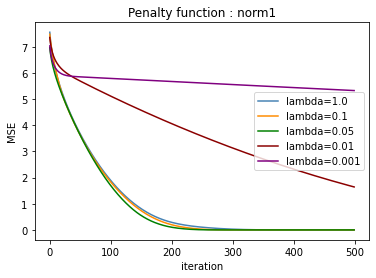

penalty_func: norm2
MSE: {1.0: 4.92775161831174e-07, 0.1: 1.2695020418659738e-08, 0.05: 6.682750079913245e-09, 0.01: 2.759944289566673, 0.001: 5.6579125787437565}


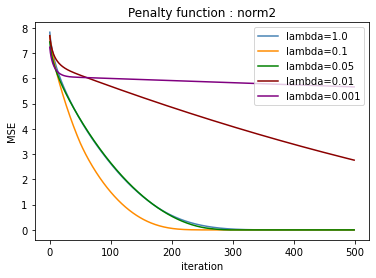

penalty_func: mocha
MSE: {1.0: 0.0012215305017091182, 0.1: 0.00814123292875352, 0.05: 0.10891135044252273, 0.01: 2.5131538119279773, 0.001: 5.954278546330874}


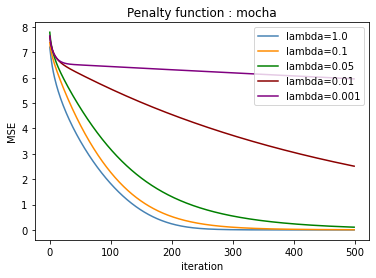

In [20]:
POUT = 0.001
lambda_lassos = [1.0, 0.1, 0.05, 0.01, 0.001]
colors = ['steelblue', 'darkorange', 'green', 'darkred', 'purple']
x1 = [i for i in range(K)]
for penalty_func in PENALTY_FUNCS:
    
    plt.close()
    MSEs = {}
    for i, lambda_lasso in enumerate(lambda_lassos):
        B, weight_vec, true_labels, datapoints = get_sbm_2blocks_data(pin=0.5, pout=POUT)
        
        samplingset = random.sample([i for i in range(N)], k=int(M * N))
                
        iteration_scores, predicted_w = algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func, calculate_score=True)
        
        alg1_score = get_score(datapoints, predicted_w, true_labels)
        MSEs[lambda_lasso] = alg1_score
        
        plt.plot(x1, iteration_scores, label='lambda='+str(lambda_lasso), c=colors[i])
    
    print('penalty_func:', penalty_func)
    print('MSE:', MSEs)
    
    plt.xlabel('iteration')
    plt.ylabel('MSE')
    plt.title('Penalty function : %s' % penalty_func)
    plt.legend(loc='best')
    plt.show()



### Different sampling ratios for each penalty functions with pout=0.001

penalty_func: norm1
MSE: {0.2: 8.89351555065316e-05, 0.4: 8.098248292499353e-07, 0.6: 1.1380283260083147e-08, 0.8: 5.2830674410165274e-09, 1.0: 2.6912206264740643e-09}


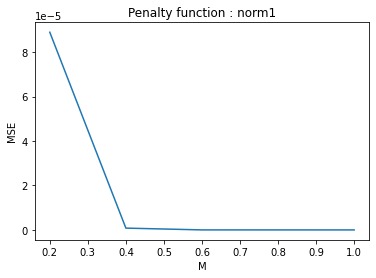

penalty_func: norm2
MSE: {0.2: 0.0002583771529449093, 0.4: 1.9643044152557672e-07, 0.6: 7.567213670373676e-09, 0.8: 1.164547311268322e-08, 1.0: 2.773597550294463e-09}


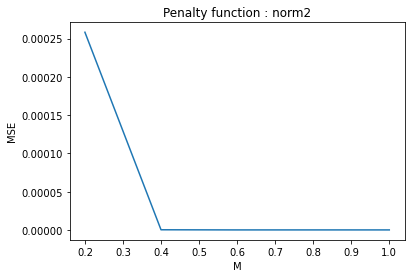

penalty_func: mocha
MSE: {0.2: 0.00316241577166385, 0.4: 0.00031286609024362146, 0.6: 0.00041527353084199245, 0.8: 0.00042588664786242435, 1.0: 8.003875601850601e-05}


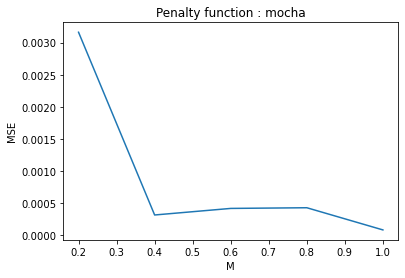

In [22]:
POUT = 0.001
lambda_lassos = {'norm1': 0.1, 'norm2': 0.1, 'mocha': 1.0}
sampling_ratios = [0.2, 0.4, 0.6, 0.8, 1.0]
colors = ['steelblue', 'darkorange', 'green', 'darkred', 'purple']
for penalty_func in PENALTY_FUNCS:
    
    MSEs = {}
    for i, sampling_ratio in enumerate(sampling_ratios):
        B, weight_vec, true_labels, datapoints = get_sbm_2blocks_data(pin=0.5, pout=POUT)
        
        samplingset = random.sample([i for i in range(N)], k=int(sampling_ratio * N))
                
        lambda_lasso = lambda_lassos[penalty_func]
        _, predicted_w = algorithm_1(300, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func)
        
        alg1_score = get_score(datapoints, predicted_w, true_labels)
        MSEs[sampling_ratio] = alg1_score
        
    
    print('penalty_func:', penalty_func)
    print('MSE:', MSEs)
    
    plt.close()
    plt.plot(list(MSEs.keys()), list(MSEs.values()))
    plt.xlabel('M')
    plt.ylabel('MSE')
    plt.title('Penalty function : %s' % penalty_func)
    plt.show()



### Different pouts and sampling ratios for each penalty function with fixed lambda

penalty_func: norm1
M: 0.2
MSE: {0.0: 5.133162130227324e-15, 0.01: 2.119195132684033e-05, 0.05: 0.001556188189872617, 0.1: 2.9406092557944055, 0.2: 3.8816694807787124, 0.4: 3.8172068600400046, 0.6: 3.1777104488238077}
M: 0.4
MSE: {0.0: 5.22607280546741e-15, 0.01: 5.032851179960787e-06, 0.05: 0.00015999583763840494, 0.1: 0.0005754165789393921, 0.2: 2.8557173232538986, 0.4: 2.443348012612449, 0.6: 3.234036954575031}
M: 0.6
MSE: {0.0: 4.867558403695794e-15, 0.01: 3.585407455028897e-06, 0.05: 6.202577268127514e-05, 0.1: 0.0002670828821806939, 0.2: 0.001278082932221612, 0.4: 3.1643477864465166, 0.6: 1.591088594811716}


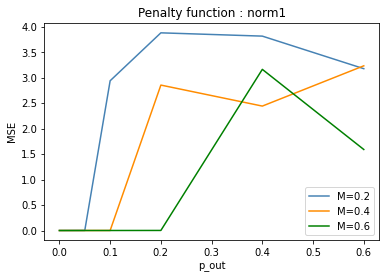

penalty_func: norm2
M: 0.2
MSE: {0.0: 4.470800527602724e-15, 0.01: 3.539665499950983e-05, 0.05: 0.20740630744826002, 0.1: 3.1542637063515104, 0.2: 3.8893359855017295, 0.4: 3.94198707869933, 0.6: 3.2970126665877415}
M: 0.4
MSE: {0.0: 4.854800502356689e-15, 0.01: 1.02908204321383e-05, 0.05: 0.00017452452992667148, 0.1: 0.0010071339568541522, 0.2: 3.411654191219076, 0.4: 2.7968723772358346, 0.6: 4.50399822255984}
M: 0.6
MSE: {0.0: 4.642757918147447e-15, 0.01: 2.9917417032233684e-06, 0.05: 8.291539263188267e-05, 0.1: 0.00036445634641021576, 0.2: 0.0011830060972503932, 0.4: 2.3373717414036603, 0.6: 1.7695737526299342}


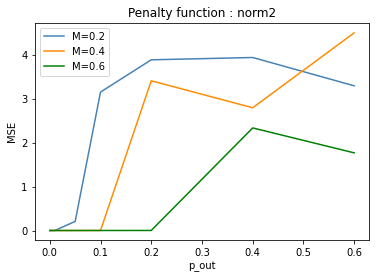

penalty_func: mocha
M: 0.2
MSE: {0.0: 0.02271775435633587, 0.01: 0.1358606664780099, 0.05: 1.0018920662559654, 0.1: 1.6818635751995312, 0.2: 2.395815506923897, 0.4: 3.224623602333075, 0.6: 3.499293107947743}
M: 0.4
MSE: {0.0: 6.040460319936277e-05, 0.01: 0.03244973334974393, 0.05: 0.34634614400486086, 0.1: 0.8258655779675455, 0.2: 1.3907492315397965, 0.4: 2.0987278970353938, 0.6: 2.586421137501767}
M: 0.6
MSE: {0.0: 1.0846236630235006e-07, 0.01: 0.009010224439919726, 0.05: 0.13150047436494336, 0.1: 0.32086779210429706, 0.2: 0.851024325201843, 0.4: 1.247077208477919, 0.6: 1.880503111207286}


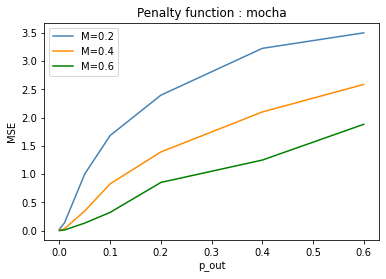

In [49]:
lambda_lasso = 0.01
pouts = [0.0, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6]
colors = ['steelblue', 'darkorange', 'green', 'darkred', 'purple']

for penalty_func in PENALTY_FUNCS:
    print('penalty_func:', penalty_func)

    for i, sampling_ratio in enumerate([0.2, 0.4, 0.6]):
        MSEs = {}
        for pout in pouts:
        
            B, weight_vec, true_labels, datapoints = get_sbm_2blocks_data(pin=0.5, pout=pout, is_torch_model=False)

        
            samplingset = random.sample([i for i in range(N)], k=int(sampling_ratio * N))


            _, predicted_w = algorithm_1(3000, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func)

            alg1_score = get_score(datapoints, predicted_w, true_labels)
            MSEs[pout] = alg1_score
        plt.plot(list(MSEs.keys()), list(MSEs.values()), label='M=' + str(sampling_ratio), c=colors[i])

        print('M:', sampling_ratio)
        print('MSE:', MSEs)
    
    plt.xlabel('p_out')
    plt.ylabel('MSE')
    plt.legend(loc='best')
    plt.title('Penalty function : %s' % penalty_func)
    plt.show()
    plt.close()
    

### Different pouts and noises for each penalty function with fixed lambda and sampling ratio

penalty_func: norm1
noise 0.01
MSE: {0.0: 0.00011197575268964638, 0.01: 0.0001113493411921468, 0.05: 0.00017596075564701088, 0.1: 0.00040157658522407076, 0.2: 0.0012107779314913098, 0.4: 1.5029878697776047, 0.6: 1.9601897075308596}
noise 0.1
MSE: {0.0: 0.008577871749918854, 0.01: 0.00756354257296714, 0.05: 0.009295587389047483, 0.1: 0.008394006385521308, 0.2: 0.012428896783235827, 0.4: 1.8425551332403032, 0.6: 2.863643548409676}
noise 1.0
MSE: {0.0: 0.7089546721943265, 0.01: 0.7034259751840699, 0.05: 0.8402843217708259, 0.1: 0.8295689674650317, 0.2: 0.7378204184967657, 0.4: 2.151569546537637, 0.6: 2.819068308111323}


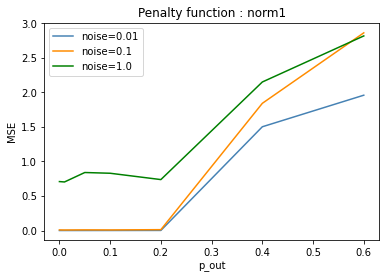

penalty_func: norm2
noise 0.01
MSE: {0.0: 9.877988967296476e-05, 0.01: 0.00010725798711467287, 0.05: 0.00018691893762769654, 0.1: 0.0003959412954883987, 0.2: 0.0017324608439702742, 0.4: 1.5881025124663928, 0.6: 2.71923031883949}
noise 0.1
MSE: {0.0: 0.008374681109383535, 0.01: 0.008398176063035728, 0.05: 0.007954323972852076, 0.1: 0.009797970626045066, 0.2: 0.025927272198529215, 0.4: 1.6043665028243954, 0.6: 1.84891727375846}
noise 1.0
MSE: {0.0: 0.7390370056110594, 0.01: 0.6204652965722304, 0.05: 0.9692390369057378, 0.1: 0.7252126937581618, 0.2: 0.8805356006261181, 0.4: 2.363280330691174, 0.6: 2.7347122822939927}


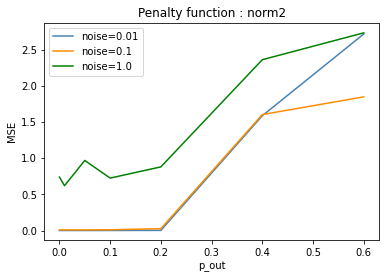

penalty_func: mocha
noise 0.01
MSE: {0.0: 0.00011676778675932589, 0.01: 0.010109807869942443, 0.05: 0.13308946833405427, 0.1: 0.34312119922911555, 0.2: 0.8806344521367, 0.4: 1.4456109238356258, 0.6: 1.7033508740341055}
noise 0.1
MSE: {0.0: 0.008200109276197756, 0.01: 0.016361750212488153, 0.05: 0.14109624777680635, 0.1: 0.40048860406417813, 0.2: 0.9011306116999769, 0.4: 1.4204886954714824, 0.6: 1.750805562130872}
noise 1.0
MSE: {0.0: 0.953123749462985, 0.01: 0.7843354638574108, 0.05: 0.9602105132156489, 0.1: 1.1252259546835528, 0.2: 1.56885447298128, 0.4: 2.218366124712282, 0.6: 2.456326867663379}


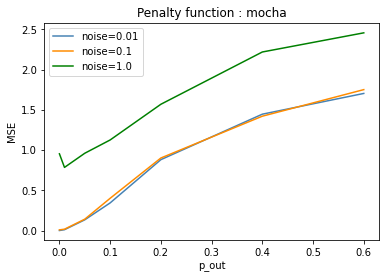

In [18]:
lambda_lasso = 0.01
sampling_ratio = 0.6
pouts = [0.0, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6]
colors = ['steelblue', 'darkorange', 'green', 'darkred', 'purple']

for penalty_func in PENALTY_FUNCS:
    print('penalty_func:', penalty_func)

    for i, noise in enumerate([0.01, 0.1, 1.0]):
        MSEs = {}
        for pout in pouts:

            B, weight_vec, true_labels, datapoints = get_sbm_2blocks_data(pin=0.5, pout=pout, noise_sd=noise, is_torch_model=False)


            samplingset = random.sample([i for i in range(N)], k=int(sampling_ratio * N))


            _, predicted_w = algorithm_1(2000, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func)

            alg1_score = get_score(datapoints, predicted_w, true_labels)
            MSEs[pout] = alg1_score

        plt.plot(list(MSEs.keys()), list(MSEs.values()), label='noise=' + str(noise), c=colors[i])

        print('noise', noise)
        print('MSE:', MSEs)

    plt.xlabel('p_out')
    plt.ylabel('MSE')
    plt.legend(loc='best')
    plt.title('Penalty function : %s' % penalty_func)
    plt.show()
    plt.close()
    

<!-- ### Different pouts and noises for each penalty function with dynamic lambda and sampling ratio -->
### test

------------------------------------
penalty_func: norm1
sampling_ratio: 0.2
lambda_lasso 0.1
MSE: {0.01: 0.003062691885655368, 0.05: 0.08432841116201731, 0.1: 4.995524420339592, 0.2: 5.264907637763058}
lambda_lasso 0.05
MSE: {0.01: 0.0006449782896127394, 0.05: 0.01668777180451969, 0.1: 3.8633777104471276, 0.2: 5.814312552480123}
lambda_lasso 0.01
MSE: {0.01: 3.321930197150884e-05, 0.05: 0.15555041182289123, 0.1: 3.2704188869354995, 0.2: 3.280102881809796}
lambda_lasso 0.005
MSE: {0.01: 0.07078334719909153, 0.05: 0.9571349681549597, 0.1: 3.4382074457053413, 0.2: 3.4005641163963225}
lambda_lasso 0.0001
MSE: {0.01: 5.972143731251853, 0.05: 6.276893927939384, 0.1: 6.0989620348064175, 0.2: 6.283838452243873}


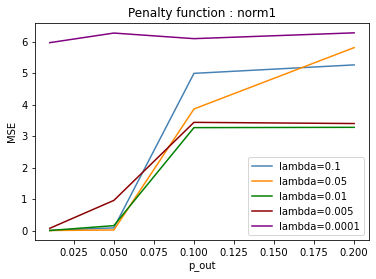

sampling_ratio: 0.25
lambda_lasso 0.1
MSE: {0.01: 0.0017992975371435038, 0.05: 0.04127185287094822, 0.1: 0.42138613136608394, 0.2: 2.980611768734821}
lambda_lasso 0.05
MSE: {0.01: 0.00043291173631899266, 0.05: 0.009631942089523626, 0.1: 0.0589810189620366, 0.2: 5.61401240120326}
lambda_lasso 0.01
MSE: {0.01: 1.6738864598210576e-05, 0.05: 0.0004926630207684629, 0.1: 1.1624029924010266, 0.2: 3.304622101272509}
lambda_lasso 0.005
MSE: {0.01: 0.013889350932302758, 0.05: 0.8734211031486867, 0.1: 1.9646833243880626, 0.2: 2.9978884057598263}
lambda_lasso 0.0001
MSE: {0.01: 5.313316023878357, 0.05: 5.688166535136553, 0.1: 6.269711238515738, 0.2: 5.871832470139589}


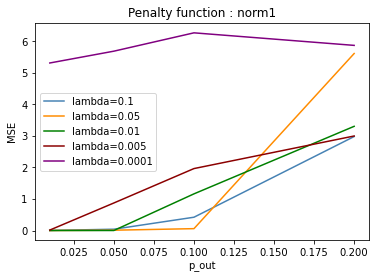

sampling_ratio: 0.3
lambda_lasso 0.1
MSE: {0.01: 0.0015456477467771712, 0.05: 0.02503882833768021, 0.1: 0.13572328615465984, 0.2: 3.994077233018359}
lambda_lasso 0.05
MSE: {0.01: 0.0005230256949619208, 0.05: 0.011002146504759992, 0.1: 0.030822378612703327, 0.2: 4.6079461870055445}
lambda_lasso 0.01
MSE: {0.01: 1.1898216215831011e-05, 0.05: 0.0003038593921695443, 0.1: 0.29930008444321815, 0.2: 2.773943917036985}
lambda_lasso 0.005
MSE: {0.01: 3.150626654745293e-06, 0.05: 0.01865746120926601, 0.1: 1.5126083997081188, 0.2: 3.4129896969058526}
lambda_lasso 0.0001
MSE: {0.01: 5.043294260962144, 0.05: 5.621559719438149, 0.1: 5.710377501190741, 0.2: 5.495594032201376}


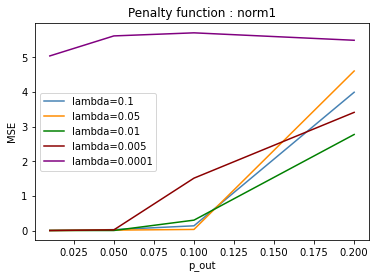

sampling_ratio: 0.4
lambda_lasso 0.1
MSE: {0.01: 0.0005482418021051253, 0.05: 0.013423152179820633, 0.1: 0.08745069555404285, 0.2: 3.744776630097526}
lambda_lasso 0.05
MSE: {0.01: 0.0001589380088169556, 0.05: 0.0032209825954855552, 0.1: 0.020172785843397153, 0.2: 3.8103786474717736}
lambda_lasso 0.01
MSE: {0.01: 6.781205526146083e-06, 0.05: 0.00016566775213462987, 0.1: 0.0006340225706372656, 0.2: 2.6869748699699847}
lambda_lasso 0.005
MSE: {0.01: 1.0185985550654645e-06, 0.05: 3.4363572916737044e-05, 0.1: 0.2836178034478759, 0.2: 2.348849562640207}
lambda_lasso 0.0001
MSE: {0.01: 4.797984848565847, 0.05: 4.375692340907217, 0.1: 4.453698603820697, 0.2: 4.5788111437292045}


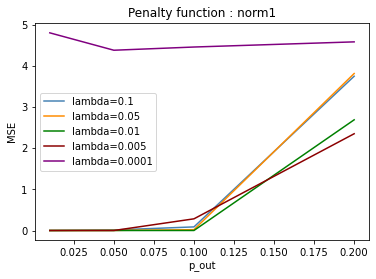

------------------------------------
penalty_func: norm2
sampling_ratio: 0.2
lambda_lasso 0.1
MSE: {0.01: 0.003366897204457218, 0.05: 0.13880150444197364, 0.1: 5.765957532143515, 0.2: 6.218465584097176}
lambda_lasso 0.05
MSE: {0.01: 0.0006875728996266935, 0.05: 0.020654127422323566, 0.1: 3.3391477467453305, 0.2: 5.196495491028091}
lambda_lasso 0.01
MSE: {0.01: 3.2981914943160265e-05, 0.05: 0.48710101007879636, 0.1: 3.1742391159071675, 0.2: 3.5283130284252975}
lambda_lasso 0.005
MSE: {0.01: 1.0330369235596382, 0.05: 2.3097369313976968, 0.1: 3.630902672781594, 0.2: 3.951997547111089}
lambda_lasso 0.0001
MSE: {0.01: 7.003807419354461, 0.05: 6.762501961725931, 0.1: 6.634776141502354, 0.2: 6.1937417516601325}


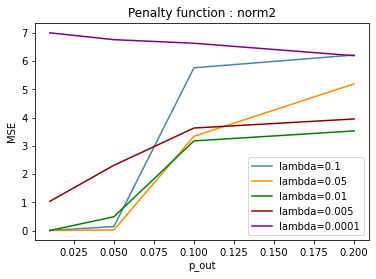

sampling_ratio: 0.25
lambda_lasso 0.1
MSE: {0.01: 0.0020716860524197514, 0.05: 0.05348875592852888, 0.1: 0.2717728199737832, 0.2: 3.024749035080842}
lambda_lasso 0.05
MSE: {0.01: 0.00028062745818543554, 0.05: 0.012179026834523037, 0.1: 0.19579418649599462, 0.2: 3.5835544319049633}
lambda_lasso 0.01
MSE: {0.01: 1.5260146509412532e-05, 0.05: 0.0005028357035744468, 0.1: 1.9950947426456254, 0.2: 3.218147912916963}
lambda_lasso 0.005
MSE: {0.01: 0.24383289333518837, 0.05: 0.8907831167398748, 0.1: 3.0570467539900923, 0.2: 3.0764124545074765}
lambda_lasso 0.0001
MSE: {0.01: 5.584584156505503, 0.05: 5.22627034794089, 0.1: 6.106569666563097, 0.2: 5.93225306584687}


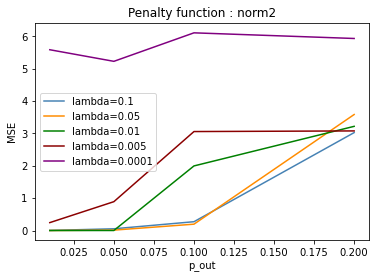

sampling_ratio: 0.3
lambda_lasso 0.1
MSE: {0.01: 0.001172072252975593, 0.05: 0.028188936272494268, 0.1: 0.1277758648348136, 0.2: 3.8419777412223355}
lambda_lasso 0.05
MSE: {0.01: 0.0001868642547201216, 0.05: 0.007837890755393342, 0.1: 0.045841875665367605, 0.2: 4.386995188342178}
lambda_lasso 0.01
MSE: {0.01: 1.624896909124958e-05, 0.05: 0.0012651218096831395, 0.1: 0.4361557593813443, 0.2: 2.9397233726459246}
lambda_lasso 0.005
MSE: {0.01: 1.2558743443611429e-05, 0.05: 0.4738897348173478, 0.1: 1.9386270497848197, 0.2: 3.653914739123617}
lambda_lasso 0.0001
MSE: {0.01: 5.226219363380988, 0.05: 5.963183118347721, 0.1: 5.278806750492808, 0.2: 5.411440356700246}


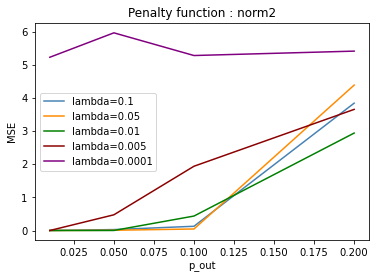

sampling_ratio: 0.4
lambda_lasso 0.1
MSE: {0.01: 0.0004482213209785332, 0.05: 0.02004071002348428, 0.1: 0.08716286238573641, 0.2: 3.1800432621298156}
lambda_lasso 0.05
MSE: {0.01: 0.00012768596378489482, 0.05: 0.00399218464539264, 0.1: 0.017809995276161332, 0.2: 5.4231660662374175}
lambda_lasso 0.01
MSE: {0.01: 4.422591105420034e-06, 0.05: 0.00018346362326804804, 0.1: 0.0007161716299978755, 0.2: 2.29384302698422}
lambda_lasso 0.005
MSE: {0.01: 2.599291533464398e-06, 0.05: 6.945131739550259e-05, 0.1: 0.38211378036245414, 0.2: 2.630449143789127}
lambda_lasso 0.0001
MSE: {0.01: 4.1899396527590165, 0.05: 4.94590609013187, 0.1: 4.951472094152907, 0.2: 4.283249789926397}


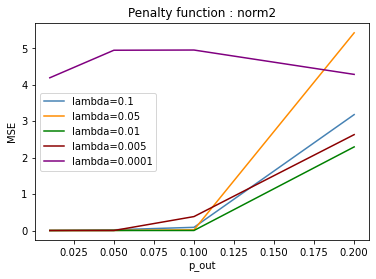

------------------------------------
penalty_func: mocha
sampling_ratio: 0.2
lambda_lasso 0.1
MSE: {0.01: 0.14963124987755608, 0.05: 1.254702025337534, 0.1: 2.1604728902048493, 0.2: 3.1647618551692926}
lambda_lasso 0.05
MSE: {0.01: 0.10889693985650747, 0.05: 1.0494786623280121, 0.1: 1.8755681870011407, 0.2: 2.482724029378242}
lambda_lasso 0.01
MSE: {0.01: 0.3230129666254987, 0.05: 1.1876721637562653, 0.1: 1.9139502251716674, 0.2: 3.00790498138569}
lambda_lasso 0.005
MSE: {0.01: 1.0897307352564896, 0.05: 1.7275168020123874, 0.1: 2.1569344902165457, 0.2: 3.0791773656129244}
lambda_lasso 0.0001
MSE: {0.01: 5.4966396571615, 0.05: 6.2565893853918295, 0.1: 6.019897610025369, 0.2: 6.362053183237103}


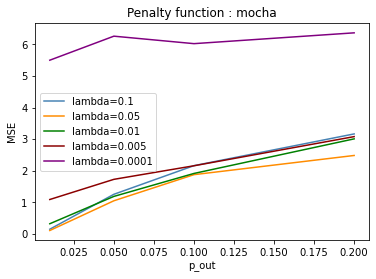

sampling_ratio: 0.25
lambda_lasso 0.1
MSE: {0.01: 0.1709783117896778, 0.05: 0.9286822423827319, 0.1: 1.8422190266054024, 0.2: 2.7879288293158013}
lambda_lasso 0.05
MSE: {0.01: 0.10761261103859061, 0.05: 0.8032081697311174, 0.1: 1.8602842231145214, 0.2: 2.3613469451082607}
lambda_lasso 0.01
MSE: {0.01: 0.2040441180081325, 0.05: 0.7143517019552974, 0.1: 1.4977417772565063, 0.2: 2.2557207239924666}
lambda_lasso 0.005
MSE: {0.01: 0.6880931965412531, 0.05: 1.7003314580788693, 0.1: 1.7982255779356877, 0.2: 2.5034815681732474}
lambda_lasso 0.0001
MSE: {0.01: 5.236316091051951, 0.05: 5.832840586986338, 0.1: 5.554150175867752, 0.2: 5.766168894091168}


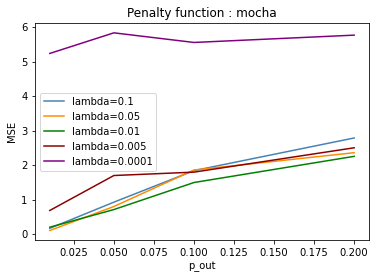

sampling_ratio: 0.3
lambda_lasso 0.1
MSE: {0.01: 0.08300416758414507, 0.05: 0.8377437186225695, 0.1: 1.7528402010579043, 0.2: 2.424942474306849}
lambda_lasso 0.05
MSE: {0.01: 0.06442060974883597, 0.05: 0.6624979514988024, 0.1: 1.1788603243774771, 0.2: 1.9575525663256825}
lambda_lasso 0.01
MSE: {0.01: 0.0930688607540799, 0.05: 0.6400077899053299, 0.1: 1.4569627644368919, 0.2: 1.936482263150572}
lambda_lasso 0.005
MSE: {0.01: 0.37579750922777483, 0.05: 0.7881421908503139, 0.1: 1.4386902087915916, 0.2: 2.039065564462481}
lambda_lasso 0.0001
MSE: {0.01: 5.077390040334997, 0.05: 5.357217622552446, 0.1: 5.157127467793844, 0.2: 4.943062211572655}


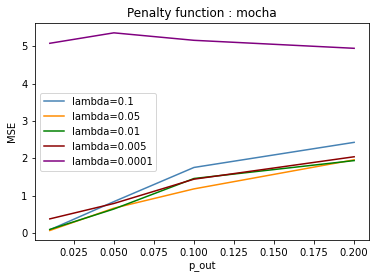

sampling_ratio: 0.4
lambda_lasso 0.1
MSE: {0.01: 0.043395649974264996, 0.05: 0.4217928509454317, 0.1: 1.0903461011870506, 0.2: 2.230972983511351}
lambda_lasso 0.05
MSE: {0.01: 0.03770858175579371, 0.05: 0.4021461258391693, 0.1: 0.8823163137827652, 0.2: 1.7169277173169877}
lambda_lasso 0.01
MSE: {0.01: 0.036343657877245056, 0.05: 0.325755787659991, 0.1: 0.8882677384897544, 0.2: 1.3509176822613682}
lambda_lasso 0.005
MSE: {0.01: 0.17064032145751676, 0.05: 0.651894186486935, 0.1: 0.9896641510979267, 0.2: 1.5787317698538559}
lambda_lasso 0.0001
MSE: {0.01: 4.249755049721186, 0.05: 4.049499896942901, 0.1: 4.529336263688768, 0.2: 5.007668783112192}


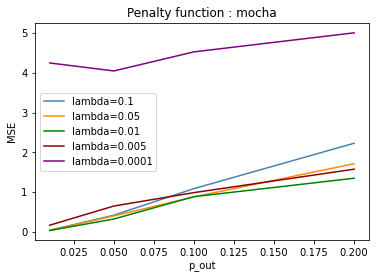

In [17]:
sampling_ratio = 0.6
pouts = [0.01, 0.05, 0.1, 0.2]
colors = ['steelblue', 'darkorange', 'green', 'darkred', 'purple']
PIN = 0.5

for penalty_func in PENALTY_FUNCS:
    print('------------------------------------')
    print('penalty_func:', penalty_func)
    for sampling_ratio in [0.2, 0.25, 0.3, 0.4]:
        print('sampling_ratio:', sampling_ratio)
        for i, lambda_lasso in enumerate([0.1, 0.05, 0.01, 0.005, 0.0001]):
            MSEs = {}
            for pout in pouts:

                B, weight_vec, true_labels, datapoints = get_sbm_2blocks_data(pin=PIN, pout=pout, is_torch_model=False)

                samplingset = random.sample([i for i in range(N)], k=int(sampling_ratio * N))

                _, predicted_w = algorithm_1(2000, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func)

                alg1_score = get_score(datapoints, predicted_w, true_labels)
                MSEs[pout] = alg1_score

            plt.plot(list(MSEs.keys()), list(MSEs.values()), label='lambda=' + str(lambda_lasso), c=colors[i])

            print('lambda_lasso', lambda_lasso)
            print('MSE:', MSEs)

        plt.xlabel('p_out')
        plt.ylabel('MSE')
        plt.legend(loc='best')
        plt.title('Penalty function : %s' % penalty_func)
        plt.show()
        plt.close()

penalty_func: norm1 pout: 0.0
noise MSE: {0: 1.4178859367823341e-08, 0.01: 9.505896873029422e-05, 0.1: 0.009111485494220953}
penalty_func: norm1 pout: 0.001
noise MSE: {0: 4.3078900246935826e-08, 0.01: 8.319461811038074e-05, 0.1: 0.01137399524769252}
penalty_func: norm1 pout: 0.1
noise MSE: {0: 4.331300872864871, 0.01: 4.052339321458038, 0.1: 4.376707755344356}
penalty_func: norm1 pout: 0.2
noise MSE: {0: 4.420807548171662, 0.01: 3.9681697450624727, 0.1: 3.886810065986162}
penalty_func: norm1 pout: 0.6
noise MSE: {0: 5.606866326530658, 0.01: 4.759506436648439, 0.1: 6.03700550381998}


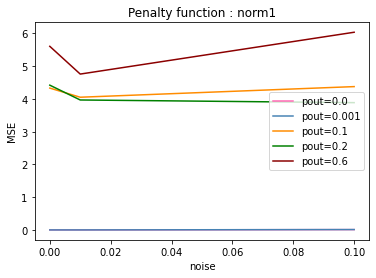

penalty_func: norm2 pout: 0.0
noise MSE: {0: 1.6004886697957799e-06, 0.01: 9.493637682846585e-05, 0.1: 0.009195034163104392}
penalty_func: norm2 pout: 0.001
noise MSE: {0: 2.4589256787924543e-07, 0.01: 0.00012022645183691002, 0.1: 0.009379333047458221}
penalty_func: norm2 pout: 0.1
noise MSE: {0: 4.13855035215799, 0.01: 5.507802257597087, 0.1: 4.253356934916724}
penalty_func: norm2 pout: 0.2
noise MSE: {0: 4.279990802063883, 0.01: 3.954846754827989, 0.1: 4.457957607956468}
penalty_func: norm2 pout: 0.6
noise MSE: {0: 4.212640373448071, 0.01: 4.3148466723198835, 0.1: 4.859208782035939}


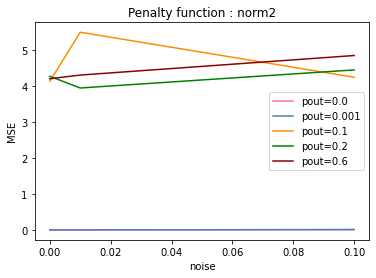

penalty_func: mocha pout: 0.0
noise MSE: {0: 2.175470727122179e-05, 0.01: 0.00013655059492942152, 0.1: 0.009390270968214758}
penalty_func: mocha pout: 0.001
noise MSE: {0: 0.0003737766702134008, 0.01: 0.0006342360279913348, 0.1: 0.01198289523302159}
penalty_func: mocha pout: 0.1
noise MSE: {0: 3.9319582245333295, 0.01: 5.7882088655302955, 0.1: 3.968006368369122}
penalty_func: mocha pout: 0.2
noise MSE: {0: 4.4059693972122655, 0.01: 4.372661105309913, 0.1: 4.137383504527408}
penalty_func: mocha pout: 0.6
noise MSE: {0: 4.317895792626453, 0.01: 4.540258874436274, 0.1: 4.978503036969184}


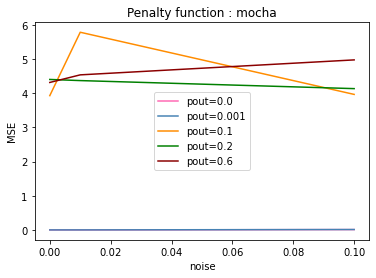

In [17]:
lambda_lassos = {'norm1': 0.1, 'norm2': 0.1, 'mocha': 1.0}
colors = ['hotpink', 'steelblue', 'darkorange', 'green', 'darkred', 'purple', 'dimgrey']
pouts = [0.0, 0.001, 0.1, 0.2, 0.6]
noises = [0, 0.01, 0.1]

for penalty_func in PENALTY_FUNCS:
    
    for i, pout in enumerate(pouts):
        
        MSEs = {}
        for noise in noises:
            B, weight_vec, true_labels, datapoints = get_sbm_2blocks_data(pin=0.5, pout=pout, noise_sd=noise)

            samplingset = random.sample([i for i in range(N)], k=int(M * N))

            lambda_lasso = lambda_lassos[penalty_func]
            _, predicted_w = algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func)

            alg1_score = get_score(datapoints, predicted_w, true_labels)
            MSEs[noise] = alg1_score

        plt.plot(list(MSEs.keys()), list(MSEs.values()), label='pout='+str(pout), c=colors[i])
        print('penalty_func:', penalty_func, 'pout:', pout)
        print('noise MSE:', MSEs)
        
    plt.xlabel('noise')
    plt.ylabel('MSE')
    plt.title('Penalty function : %s' % penalty_func)
    plt.legend(loc='best')
    plt.show()
    plt.close()

